In [2]:
# Import packages
from pymongo import MongoClient
import pandas as pd
from karateclub import Diff2Vec
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import faiss
import seaborn as sns

In [3]:
# Connect to db collections
client = MongoClient('mongodb://localhost:27017/')
db = client['address-clustering']
transfers = db['transfers']
transactions = db['transactions']

# Get addresses active on Ethereum and/or Polygon as a list
users = pd.read_csv('../data/subsets.csv')
user_addresses = list(set(users.loc[users['Polygon'] == 1, 'Address']).union(users.loc[users['Ethereum'] == 1, 'Address']))
user_addresses

['0x6cd8bb54a205864cd18473b4bbbd13053a4054e4',
 '0xc6d4a6cba7e14c36a43e6ff7d890706763ef0f90',
 '0x2d01a7396bc8dec2f9196e955cf24fc709b5da76',
 '0xe14378cfcca70f713cbccd7d7e28aab38aa04df1',
 '0xe71e1215dc352a11dcc4c63e0309f475eedf72e0',
 '0x9065511b6852bb79d300b073b05ddebaf766063e',
 '0xbe1a7daf783068c78f959ca4be8173142420d73d',
 '0x6f1f99dba6abd142664b9d73b917d39cc674508c',
 '0x23dc7aff61d93effd0020f2e92e0448433ff01e3',
 '0x4d9a87cf80db30e212ea32d4f6f904243bb14ff4',
 '0xd4935a2f0e1bbe2c84af3bf91e2909f40cdf571d',
 '0xaffb9ad129e2966e60701c32d4028fdf6ffc27f9',
 '0xc0061d5dae316110d8a290b6615581027000f735',
 '0x5cc71ad43cffa864ae3b4b6c3b1cb72ffeedbe3a',
 '0xa0923ae8d0559a5158314ccf48684d60d2911c47',
 '0x433261ea05bd6e6c334385c22b848f1907f44c79',
 '0xea75a1fcea8f493cfe4d6b4726b2b4f857668472',
 '0x25c0aa06c3d765fb315a41afbd24e21f7e414297',
 '0x88f906f0fe4663fb5f6e94e41ea7eab57e555446',
 '0xe4e743a12188ed2bc9ba437834322269a7b7aa27',
 '0xd45a03fe7c0a3863dabf1368240d32529b6b8ee2',
 '0x81e497851

In [11]:
# Function to prepare dataframe to construct network graph
def prepare_dataframe(df):
    # Remove self-transfers (loops)
    df = df[df['from'] != df['to']]
    # Only keep from and to columns from the dataframe
    df = df[['from', 'to']]
    # Sort from and to addresses lexicographically
    df['from'], df['to'] = np.where(df['from'] > df['to'], [df['to'], df['from']], [df['from'], df['to']])
    # Group by 'from' and 'to', and count the number of interactions
    grouped_df = df.groupby(['from', 'to']).size().reset_index(name='interactions')
    grouped_df = grouped_df.rename(columns={"from": "address1", "to": "address2"})
    # Only keep rows where weight is greater than 1
    #grouped_df = grouped_df[grouped_df['interactions'] > 1]
    return grouped_df

def clean_graph(G):
    G_undir = G.to_undirected()
    G_tmp = nx.Graph()
    G_tmp.add_edges_from(G_undir.edges())
    G_tmp.remove_edges_from(nx.selfloop_edges(G_tmp))
    return G_tmp

def recode_graph(G):
    N = G.number_of_nodes()
    node_map = dict(zip(G.nodes(), range(N)))
    edges_addr = list(G.edges())
    edges_idx = [(node_map[src], node_map[trg]) for src, trg in edges_addr]
    G_tmp = nx.Graph()
    G_tmp.add_edges_from(edges_idx)
    return G_tmp, node_map

## Construct intra-set transfer and transaction dataframes

In [4]:
## Intra-set transfers
query_conditions = {
    "from": {"$in": user_addresses},
    "to": {"$in": user_addresses}
}

transfer_df = pd.DataFrame(list(transfers.find(query_conditions)))

# Drop duplicates
transfer_df = transfer_df.drop(['_id', 'isSet', 'userAddress'], axis=1).drop_duplicates()#.reset_index()
transfer_df

,timeStamp,hash,from,to,contractAddress,value,nonce,tokenName,gasPrice,gasUsed,chainName,tokenType,tokenID
0,1662353592,0xb40ea5aa7be6a9bd40a401776a5cbcc79baec55abcd3...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,,262,Ethereum Name Service,11669714414,35891,Ethereum,721,9195376066544224579801628165307037174542546450...
4,1661006285,0x259b903f6c1ec513b9792768859cea2e429aed92375a...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x60ab31673485542e3ca55ba3a42c693863caff10,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,,76,Ethereum Name Service,10898502261,525347,Ethereum,721,2595491705420008057279971876399537371370624420...
8,1661687584,0xf028f85d40cb7ad41a95c40f36772e4fcd1c6b5e6bf3...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x8f3cf7ad23cd3cadbd9735aff958023239c6a063,0.11,61,(PoS) Dai Stablecoin,30000068397,32562,Polygon,20,
10,1649007251,0x131db9db1de6204423552c97aedf437776e4c27101b9...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x03ba161f99e0561adc546644640ba6d5602d86c8,0x493a5bad290b6f5a750e180d48074f1de31aec47,,7433,DAZZLE Fashion 2022 MVFW Catwalk,35150000000,271656,Polygon,721,13
12,1652940559,0x4fa9dea1bfef721568d7aa55140b1f7969344a44c0a7...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x0749d1abb5ca9128432b612644c0ea1e9c6cc9af,0xfdac3c4ffccb6e05d3e9a9d69ec95edeb6e8c844,,31220,AO 2022 - Accessories,37064012768,272721,Polygon,721,5265614583427859334895901384183521615944754770...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119733,1671413907,0xff4b2d8133986f6b6a9d6bbd88a2bfb1c5abee3648ea...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0xb854bf4d15be8e1f9b38e8b6af7d3283b81edfd8,,40309,ICE Poker SNG Wearables,61922750388,145726,Polygon,721,2106245833371143733958360553673408646377901908...
2119735,1671413931,0x0635f1dcc46059bfb00d29130914370cbe4bb2c8061a...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0xbcbdf467b5530d85b792d9e8afb109d7d1ac32c4,,59757,FOMO Bro NFTee,64081415590,137287,Polygon,721,162
2119737,1671413955,0xe4dde48b270b76854b461748dfc1c0f5fd0cc986a4ef...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0x873c11f798fc6f6c370c40f460aae4e20069b105,,96970,Roland Lifestyle DCLMVMF 2022,64737010321,162802,Polygon,721,732
2119739,1652154158,0x085c04dacb55543e2333f84395b3ae93b8631c69d57f...,0xffffca7879d31e91047d37193a5b806f5f791848,0x16efdf4ef182a5b82221fed14f4c3996922d00e2,0xdac17f958d2ee523a2206206994597c13d831ec7,100.0,27,Tether USD,49354171902,46085,Ethereum,20,


In [5]:
## Intra-set transactions of native asset
query_conditions = {
    "input": "0x",
    "from": {"$in": user_addresses},
    "to": {"$in": user_addresses}
}

transaction_df = pd.DataFrame(list(transactions.find(query_conditions)))

# Drop id column
transaction_df = transaction_df.drop(['_id'], axis=1).drop_duplicates()#.reset_index()
transaction_df

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName
0,0x67c44a94c7fa3deb18b52c8725daf4e1285028a88201...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1686282535,189.0,0.000000e+00,167262761118,0x,21000,,Polygon
1,0xd1870ec270e664b83bc7206d438ecbe8b61284dfa174...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688893903,204.0,0.000000e+00,67000000000,0x,21000,,Polygon
2,0x5d04935633af10fb3f2161f7c0328934145cbea17375...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688986319,205.0,0.000000e+00,110000000000,0x,21000,,Polygon
3,0x1060eb7fa78e1e3604c2e0150fff45f3224a437ec5c8...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688993888,206.0,0.000000e+00,102000000000,0x,21000,,Polygon
4,0x68f79a067b1bf334e9e1634bc04e49ede5255d57e6c3...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688994700,207.0,0.000000e+00,87000000000,0x,21000,,Polygon
...,...,...,...,...,...,...,...,...,...,...,...
302857,0xb518d37f14b802ce6bfb87f03122ed5fc6ff6e6a09df...,0xfffc3e3e4f27e609433ab9dfb50cb2bdef1ba4f8,0xfffc3e3e4f27e609433ab9dfb50cb2bdef1ba4f8,1640826618,41.0,0.000000e+00,106666666666,0x,21000,,Polygon
302858,0x79a8b4dee4dc50a7a88909e96dde5e803aea6f24e470...,0xfffc804dd1175bb079c0ee11593493df60d24c97,0xfffc804dd1175bb079c0ee11593493df60d24c97,1624801813,48.0,0.000000e+00,63800000000,0x,21000,,Ethereum
302859,0xfdc531ff5f7fc6e5282c15fa896491bae24a7e1b585f...,0xfffc804dd1175bb079c0ee11593493df60d24c97,0xfffc804dd1175bb079c0ee11593493df60d24c97,1619893785,46.0,4.804222e+17,43000000000,0x,21000,,Ethereum
302860,0xa56b5803be966f4d521244e03380198a5a5ac8401733...,0x16efdf4ef182a5b82221fed14f4c3996922d00e2,0xffffca7879d31e91047d37193a5b806f5f791848,1659260765,131.0,1.000000e+18,4759274510,0x,21000,,Ethereum


In [6]:
## Combine both dataframes
all_transfers = pd.concat([transaction_df, transfer_df], ignore_index=True)
all_transfers

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,contractAddress,tokenName,tokenType,tokenID
0,0x67c44a94c7fa3deb18b52c8725daf4e1285028a88201...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1686282535,189.0,0.0,167262761118,0x,21000,,Polygon,NaN,NaN,NaN,NaN
1,0xd1870ec270e664b83bc7206d438ecbe8b61284dfa174...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688893903,204.0,0.0,67000000000,0x,21000,,Polygon,NaN,NaN,NaN,NaN
2,0x5d04935633af10fb3f2161f7c0328934145cbea17375...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688986319,205.0,0.0,110000000000,0x,21000,,Polygon,NaN,NaN,NaN,NaN
3,0x1060eb7fa78e1e3604c2e0150fff45f3224a437ec5c8...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688993888,206.0,0.0,102000000000,0x,21000,,Polygon,NaN,NaN,NaN,NaN
4,0x68f79a067b1bf334e9e1634bc04e49ede5255d57e6c3...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688994700,207.0,0.0,87000000000,0x,21000,,Polygon,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185021,0xff4b2d8133986f6b6a9d6bbd88a2bfb1c5abee3648ea...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,1671413907,40309.0,,61922750388,NaN,145726,NaN,Polygon,0xb854bf4d15be8e1f9b38e8b6af7d3283b81edfd8,ICE Poker SNG Wearables,721.0,2106245833371143733958360553673408646377901908...
1185022,0x0635f1dcc46059bfb00d29130914370cbe4bb2c8061a...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,1671413931,59757.0,,64081415590,NaN,137287,NaN,Polygon,0xbcbdf467b5530d85b792d9e8afb109d7d1ac32c4,FOMO Bro NFTee,721.0,162
1185023,0xe4dde48b270b76854b461748dfc1c0f5fd0cc986a4ef...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,1671413955,96970.0,,64737010321,NaN,162802,NaN,Polygon,0x873c11f798fc6f6c370c40f460aae4e20069b105,Roland Lifestyle DCLMVMF 2022,721.0,732
1185024,0x085c04dacb55543e2333f84395b3ae93b8631c69d57f...,0xffffca7879d31e91047d37193a5b806f5f791848,0x16efdf4ef182a5b82221fed14f4c3996922d00e2,1652154158,27.0,100.0,49354171902,NaN,46085,NaN,Ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,20.0,


## Prepare dataframe to create network graph

In [7]:
## Remove self-loops, count number of interactions
graph_df = prepare_dataframe(all_transfers)
graph_df

# # Count unique addresses
unique_addresses = pd.concat([graph_df['address1'], graph_df['address2']]).nunique()
print(f"Number of unique addresses: {unique_addresses}")

Number of unique addresses: 56299


### Refined approach

In [16]:
## Create network graph
G = nx.from_pandas_edgelist(all_transfers, 'from', 'to', create_using=nx.Graph())
G = clean_graph(G)

# remove low degree nodes
#G = nx.k_core(G, k=core_number)

# Get the largest connected component (assuming graph is undirected)
largest_cc = max(nx.connected_components(G), key=len)
print(len(largest_cc))
# Create a subgraph of G consisting only of the nodes in the largest connected component
G_cc = G.subgraph(largest_cc)

# Recode the graph's nodes
G_cc, node_map = recode_graph(G_cc)

# Create reverse map (from indices to addresses)
idx_map = dict(zip(node_map.values(),node_map.keys()))
ordered_addresses = [idx_map[idx] for idx in range(len(node_map))]

# Initialize Diff2Vec model
model = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025) #same as in tutela
model.fit(G_cc)

# Get embeddings
embeddings = model.get_embedding()
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['address'] = ordered_addresses

51566


In [17]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,address
0,0.421179,-0.046553,0.142187,0.179774,0.549175,-0.668954,0.738654,-0.133973,-0.348434,0.409331,...,0.220349,-0.528068,0.182736,0.067469,-0.126297,0.213751,-0.679796,-0.091416,0.311561,0x000000085d9a759bb5c3d459d638739c0f48deb0
1,0.729614,0.534566,0.127794,0.541297,0.829062,-0.689123,0.588764,-0.098176,0.138452,0.191510,...,0.599884,-0.116231,0.548773,0.442948,-0.589237,-0.363598,-0.287034,-0.327888,0.604212,0x60ab31673485542e3ca55ba3a42c693863caff10
2,0.168742,-0.369170,-0.388065,0.074016,-0.182605,-0.700224,0.292082,-0.366473,-0.780694,0.094367,...,0.535266,-0.291201,0.168595,-0.113954,-0.055719,0.297448,-0.835412,0.483847,0.038056,0x37f00ec67d68c2d3c662339c183d37403c36f28e
3,-0.230112,-0.396025,0.454499,0.229131,-0.242237,0.092970,0.291959,-0.326064,0.118669,0.019879,...,0.224895,-0.089976,0.111883,-0.115871,-0.202123,0.264642,-0.044877,-0.001077,-0.217404,0x0000007c60fab7a70c2ae0ebe437f3726b05e7eb
4,-0.748084,-0.388447,1.121229,0.268011,0.154087,0.148435,0.689960,-1.218088,-0.536047,-0.847546,...,0.076357,0.525898,-0.393829,0.170638,0.209408,-0.623115,-0.206704,0.962161,-0.178918,0x765e152063e6f7dd3077980192d0564e93f126b8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51561,0.003644,-0.094473,-0.274030,0.145359,0.095958,0.082083,0.383676,-0.011453,0.070637,0.550678,...,-0.275561,-0.140404,-0.116099,0.125402,-0.345560,0.100622,-0.293827,0.245511,0.157699,0x4c8a1e0c07f2a0eca8d753443f930244a3a04ea4
51562,-0.235197,-0.029349,-0.045532,-0.336832,-0.006494,0.245431,-0.339127,-0.409868,-0.143369,-0.284265,...,-0.271707,-0.080898,-0.233396,-0.597625,-0.160284,0.254388,-0.123174,0.189372,0.461210,0xf4d1f11a3c2ccb67432ee960ad9bbb65880d21a9
51563,-0.166141,-0.300685,-0.363350,-0.366431,0.065755,0.064665,-0.385389,-0.422200,-0.067335,0.073526,...,-0.362250,0.394301,-0.253850,0.210241,-0.096020,0.354952,-0.052672,0.641154,0.083018,0xee9145301540ba833c20ba55c3bcb64cfd1769c3
51564,0.370297,0.211217,-0.025076,0.622781,-0.136601,-0.116477,0.274691,-0.445631,0.061639,0.131917,...,-0.113800,-0.032475,-0.367392,0.193605,-0.337580,-0.298703,0.122413,0.189308,0.013108,0x6db1fa17c0869b79ee74af42c19e0a1440f3603b


### Compute node embeddings using Diff2Vec

In [13]:
## Create network graph
G = nx.from_pandas_edgelist(graph_df, 'address1', 'address2', 'interactions', create_using=nx.Graph())

# Get the largest connected component (assuming graph is undirected)
largest_cc = max(nx.connected_components(G), key=len)
print(len(largest_cc))

# Create a subgraph of G consisting only of the nodes in the largest connected component
G_cc = G.subgraph(largest_cc)

# Creating a mapping of old node IDs to new node IDs
node_mapping = {node: i for i, node in enumerate(G_cc.nodes)}

# Relabeling the nodes in the graph according to the mapping
G_cc = nx.relabel_nodes(G_cc, node_mapping)

# Initialize Diff2Vec model
model = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025) #same as in tutela
model.fit(G_cc)

# Get embeddings
embeddings = model.get_embedding()
embeddings

51566


NetworkXError: Frozen graph can't be modified

In [22]:
## Manual check of Address Pair
idx1 = embeddings_df[embeddings_df['address'] == '0x85e5472752a6f00775faca4d5179bde1081571b0'].index.item()
idx2 = embeddings_df[embeddings_df['address'] == '0xbf886e3069d0dfd64e384c93da322f775faa8876'].index.item()
#idx1 = node_mapping['0x85e5472752a6f00775faca4d5179bde1081571b0']
#idx2 = node_mapping['0xbf886e3069d0dfd64e384c93da322f775faa8876']
print(idx1,idx2)

34899 34901


### Find k nearest neighbours using FAISS

In [23]:
# Assuming `embeddings` is a 2D numpy array where each row is the embedding of a node
# Normalize embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Build the index
index = faiss.IndexFlatL2(embeddings.shape[1])

# Add vectors to the index
index.add(embeddings)

# Query the index for the nearest neighbors of any embedding
D, I = index.search(embeddings[idx1:idx1+1], k=30)

# D and I are the distances and indices of the nearest neighbors, respectively
print(D)  # Distance to nearest neighbors
print(I)  # Indices of nearest neighbors


[[0.         0.5018554  0.52201164 0.5957526  0.628039   0.810272
  0.8254644  0.87807345 1.0277601  1.0841581  1.0935464  1.1040522
  1.1180125  1.14423    1.1533135  1.1579843  1.1592032  1.1652615
  1.1701431  1.1707379  1.1737895  1.1745033  1.1808927  1.1815057
  1.183559   1.1881876  1.1902595  1.1921837  1.2003042  1.2072392 ]]
[[34899 34902 34136 34901 34898 33752 46886 46390  9032 33753 34904 27712
  46391 34844 33747 36495 34897 31848 34896 34900 31143 43156 43159 25180
  38041 43164 10635 35022 26599 36498]]


In [38]:
## Function to find the rank and distance of the right address in my ground truth set
def find_rank_and_distance(row):
    addresses = row['Addresses']  # Addresses should already be a list

    if addresses[0] not in node_mapping or addresses[1] not in node_mapping:
        return None, None  # Skip if addresses are not in node_mapping

    idx1 = node_mapping[addresses[0]]
    idx2 = node_mapping[addresses[1]]

    # Search the k nearest neighbours for address i
    D, I = index.search(embeddings[idx1:idx1+1], k=50000)

    # Find the rank and distance of the second address among these neighbours
    if idx2 in I:
        rank = np.where(I == idx2)[1][0]
        distance = D[0][rank]  # Get the corresponding distance
    else:
        rank = None
        distance = None

    return rank, distance

## ENS dataset
df = pd.read_csv('../data/ens_list.csv')

# Group by ENS Name and filter groups with 2 addresses
grouped_df = df.groupby('ENS Name').filter(lambda x: len(x) > 1)

# for each ENS name in the DF, get a list of associated addresses
data = []
for ens_name, group in grouped_df.groupby('ENS Name'):
    addresses = group['Address'].tolist()
    data.append([ens_name, addresses])

ens_addresses_df = pd.DataFrame(data, columns=['ENS Name', 'Addresses'])
ens_addresses_df
# Apply the function to find the rank and distance of the right pair to each row of the dataframe
# ens_addresses_df['Rank'], ens_addresses_df['Distance'] = zip(*ens_addresses_df.apply(find_rank_and_distance, axis=1))
# print(ens_addresses_df['Distance'].mean())
# print(ens_addresses_df['Rank'].median())
# ens_addresses_df.to_csv('../other_parameters.csv')

,ENS Name,Addresses
0,anisofim.eth,"[0x85e5472752a6f00775faca4d5179bde1081571b0, 0..."
1,arisalzberg.eth,"[0x94e59547b8c68924380c90e729488f3e79ff8d22, 0..."
2,atearnz.eth,"[0x5500c014dc83d18c60858195b42f2e61f877323e, 0..."
3,awedjob.eth,"[0xc939519869c946e4bdca8fd0b6459048c4aebae2, 0..."
4,captvicky.eth,"[0x33e51a1141c44cc8bcb9b50c4a3c7ab59f4cf68c, 0..."
5,disruptor.eth,"[0xb84914f420b6de809ac1ed3d4427d90ed596b41c, 0..."
6,dragonkiller.eth,"[0x4fdafeadb7c2f127e3c1719a99c01680cc8ddab1, 0..."
7,eibriel.eth,"[0x05c351382db8d770207f319d96ac1184c3717ede, 0..."
8,epdrabbit.eth,"[0x26846c9083c4ab525de593178e3f2f82afb8ba83, 0..."
9,erikarand.eth,"[0xe005c90eb8b38938cfe722e7069118414145709b, 0..."


### New approach

In [37]:
address_embedding_dict = pd.Series(embeddings_df.drop(columns='address').values.tolist(), index=embeddings_df.address).to_dict()

def get_embedding_from_address(address):
    return address_embedding_dict[address]

def find_nearest_neighbours(address, k=10):
    # Get embedding of the address
    address_embedding = np.array(get_embedding_from_address(address)).reshape(1, -1)

    # Query the index for the nearest neighbors of the address's embedding
    D, I = index.search(address_embedding, k)

    # Translate indices back to addresses
    neighbours = [ordered_addresses[i] for i in I[0]]

    return neighbours

## Function to find the rank and distance of the right address in my ground truth set
def find_rank_and_distance(row):
    addresses = row['Addresses']  # Addresses should already be a list

    if addresses[0] not in address_embedding_dict or addresses[1] not in address_embedding_dict:
        return None, None  # Skip if addresses are not in node_mapping

    idx1 = embeddings_df[embeddings_df['address'] == addresses[0]].index.item()
    idx2 = embeddings_df[embeddings_df['address'] == addresses[1]].index.item()

    # Search the k nearest neighbours for address i
    D, I = index.search(embeddings[idx1:idx1+1], k=50000)

    # Find the rank and distance of the second address among these neighbours
    if idx2 in I:
        rank = np.where(I == idx2)[1][0]
        distance = D[0][rank]  # Get the corresponding distance
    else:
        rank = None
        distance = None

    return rank, distance

find_nearest_neighbours('0x85e5472752a6f00775faca4d5179bde1081571b0', 30)

ens_addresses_df['Rank'], ens_addresses_df['Distance'] = zip(*ens_addresses_df.apply(find_rank_and_distance, axis=1))
print(ens_addresses_df['Distance'].mean())
print(ens_addresses_df['Rank'].median())
print(ens_addresses_df['Rank'].mean())
ens_addresses_df

0.9187945566679302
3.5
44.31578947368421


,ENS Name,Addresses,Rank,Distance
0,anisofim.eth,"[0x85e5472752a6f00775faca4d5179bde1081571b0, 0...",3.0,0.595753
1,arisalzberg.eth,"[0x94e59547b8c68924380c90e729488f3e79ff8d22, 0...",9.0,1.229145
2,atearnz.eth,"[0x5500c014dc83d18c60858195b42f2e61f877323e, 0...",1.0,0.621609
3,awedjob.eth,"[0xc939519869c946e4bdca8fd0b6459048c4aebae2, 0...",43.0,1.191568
4,captvicky.eth,"[0x33e51a1141c44cc8bcb9b50c4a3c7ab59f4cf68c, 0...",NaN,NaN
5,disruptor.eth,"[0xb84914f420b6de809ac1ed3d4427d90ed596b41c, 0...",7.0,1.184267
6,dragonkiller.eth,"[0x4fdafeadb7c2f127e3c1719a99c01680cc8ddab1, 0...",12.0,0.808134
7,eibriel.eth,"[0x05c351382db8d770207f319d96ac1184c3717ede, 0...",648.0,1.557934
8,epdrabbit.eth,"[0x26846c9083c4ab525de593178e3f2f82afb8ba83, 0...",18.0,1.055943
9,erikarand.eth,"[0xe005c90eb8b38938cfe722e7069118414145709b, 0...",1.0,0.884336


In [140]:
df1 = pd.read_csv('../only_transfers.csv')
df2 = pd.read_csv('../transfersPlusNative.csv')
df3 = pd.read_csv('../other_parameters.csv')

print('Dataset: only Transfers / transfers and native / other params')
print(f'Mean Rank: {df1["Rank"].mean()} / {df2["Rank"].mean()} / {df3["Rank"].mean()}')
print(f'Median Rank: {df1["Rank"].median()} / {df2["Rank"].median()} / {df3["Rank"].median()}')
print(f'Mean Distance: {df1["Distance"].mean()} / {df2["Distance"].median()} / {df3["Distance"].mean()}')
print(f'Median Distance: {df1["Distance"].median()} / {df2["Distance"].median()} / {df3["Distance"].median()}')

Dataset: only Transfers / transfers and native / other params
Mean Rank: 68.54054054054055 / 24.18421052631579 / 17.263157894736842
Median Rank: 3.0 / 4.0 / 3.0
Mean Distance: 0.9587040140822127 / 0.9279692471027374 / 0.9096820652484894
Median Distance: 0.95011568069458 / 0.9279692471027374 / 0.9260088801383972


In [141]:
df3

,Unnamed: 0,ENS Name,Addresses,Rank,Distance
0,0,anisofim.eth,"['0x85e5472752a6f00775faca4d5179bde1081571b0',...",4.0,0.661215
1,1,arisalzberg.eth,"['0x94e59547b8c68924380c90e729488f3e79ff8d22',...",21.0,1.348246
2,2,atearnz.eth,"['0x5500c014dc83d18c60858195b42f2e61f877323e',...",2.0,0.653908
3,3,awedjob.eth,"['0xc939519869c946e4bdca8fd0b6459048c4aebae2',...",74.0,1.248078
4,4,captvicky.eth,"['0x33e51a1141c44cc8bcb9b50c4a3c7ab59f4cf68c',...",NaN,NaN
5,5,disruptor.eth,"['0xb84914f420b6de809ac1ed3d4427d90ed596b41c',...",6.0,1.221428
6,6,dragonkiller.eth,"['0x4fdafeadb7c2f127e3c1719a99c01680cc8ddab1',...",42.0,0.972515
7,7,eibriel.eth,"['0x05c351382db8d770207f319d96ac1184c3717ede',...",174.0,1.449171
8,8,epdrabbit.eth,"['0x26846c9083c4ab525de593178e3f2f82afb8ba83',...",19.0,1.123956
9,9,erikarand.eth,"['0xe005c90eb8b38938cfe722e7069118414145709b',...",1.0,0.682870


In [159]:
# Number of nearest neighbours to consider
k = 5

# This will store the clusters. Each cluster is a set of nodes (i.e., a set of indices).
clusters = []

threshold = 0.5

# Iterate over all embeddings
for i in range(embeddings.shape[0]):
    # Query the index for the k nearest neighbors of the i-th embedding
    D, I = index.search(embeddings[i:i+1], k)

    # The indices of the nearest neighbors of the i-th node are in I[0]
    neighbours = set(I[0][D[0] < threshold])

    # Check if the node is already part of a cluster
    for cluster in clusters:
        if i in cluster:
            # If the node is part of a cluster, we extend this cluster by the new neighbours
            cluster.update(neighbours)
            break
    else:
        # If the node was not part of any cluster, we create a new cluster
        clusters.append(neighbours)


print(len(clusters))
clusters
# 26,740

36566


[{0},
 {1},
 {2},
 {3,
  14205,
  16421,
  18579,
  19558,
  20368,
  24394,
  25743,
  26605,
  26778,
  27452,
  37341,
  39353,
  42582,
  44816,
  45024,
  45050,
  45052,
  45103,
  45153,
  45162,
  45168,
  45208,
  45233,
  45251,
  45253},
 {4},
 {5,
  3760,
  14205,
  19416,
  20368,
  24078,
  25270,
  26778,
  27452,
  29400,
  30800,
  35292,
  35786,
  37341,
  39337,
  39353,
  39371,
  39390,
  43261,
  44253,
  44662,
  45024,
  45037,
  45050,
  45052,
  45061,
  45158,
  45162,
  45163,
  45177,
  45180,
  45188,
  45251,
  45256},
 {6},
 {7},
 {8},
 {9},
 {10},
 {11},
 {12},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19},
 {20},
 {21},
 {22},
 {23},
 {24},
 {25},
 {26},
 {27},
 {28},
 {29},
 {30},
 {31},
 {32},
 {33},
 {34},
 {35},
 {36},
 {37},
 {38},
 {39},
 {40},
 {41, 20503, 25432, 32626, 39672, 47060, 47587},
 {42},
 {43},
 {44},
 {45},
 {46},
 {47},
 {48},
 {49},
 {50},
 {51},
 {52},
 {53},
 {54},
 {55},
 {56},
 {57,
  19476,
  21768,
  26165,
  30344,
  3776

### Manual check of clusters using time-of-day

In [160]:
# Create an inverse mapping
inverse_node_mapping = {i: node for node, i in node_mapping.items()}

# Now, let's say you have a list of node IDs you got from FAISS,
# and you want to convert them back to original addresses
faiss_node_ids = [114,19792]  # just an example, replace with your actual node IDs

# Get the original addresses
clustered_addresses = [inverse_node_mapping[node_id] for node_id in faiss_node_ids]

print(clustered_addresses)

['0x00029d35cb7ae09d38037355a046791d7b5e1645', '0x8b44b8384082bab94f31248e161b870be83ebb28']


In [161]:
addresses = ['0xf4ea960bd28359da37b9cda021b342fec9ea28df',
'0x1fbe11d4b9ca6d9299b9cb9391e5252f2050bb7e',
'0x66693f348b718771973aefb4c080d581cb20d631']
df = all[all['from'].isin(clustered_addresses)]
df

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,contractAddress,tokenName,tokenType,tokenID
210676,0x11ffe4cb849ce2c97d10ed487c2a3f22c61223b16743...,0x00029d35cb7ae09d38037355a046791d7b5e1645,0x00029d35cb7ae09d38037355a046791d7b5e1645,1647653921,280.0,,29100962882,NaN,36331,NaN,Ethereum,0xddec51fcb10ed81f532fca8d73e25480f71b7cfe,PeacefulToadz,721.0,1853
210677,0x049ece275b7f2f823b26a9a055a21c9b6efedfc74bcd...,0x00029d35cb7ae09d38037355a046791d7b5e1645,0x2586181d6544b49060d48f8c1322339ed2876f16,1635470037,165.0,333690.0,238551173765,NaN,43911,NaN,Ethereum,0xbaac2b4491727d78d2b78815144570b9f2fe8899,The Doge NFT,20.0,
775780,0x7776a6bd2ff4218adc3080d36ca238b7dc3f88dbaa43...,0x8b44b8384082bab94f31248e161b870be83ebb28,0x2586181d6544b49060d48f8c1322339ed2876f16,1664235215,203.0,0.06555,6710629504,NaN,190785,NaN,Ethereum,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,20.0,


In [162]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')  # Convert UNIX timestamps to datetime
df['hour_of_day'] = df['timeStamp'].dt.hour + df['timeStamp'].dt.minute/60  # Extract the time of the day in hours

/var/folders/6y/q2mh3ct92xx9v05c53h84l6c0000gn/T/ipykernel_37485/3726759338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')  # Convert UNIX timestamps to datetime
/var/folders/6y/q2mh3ct92xx9v05c53h84l6c0000gn/T/ipykernel_37485/3726759338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_of_day'] = df['timeStamp'].dt.hour + df['timeStamp'].dt.minute/60  # Extract the time of the day in hours


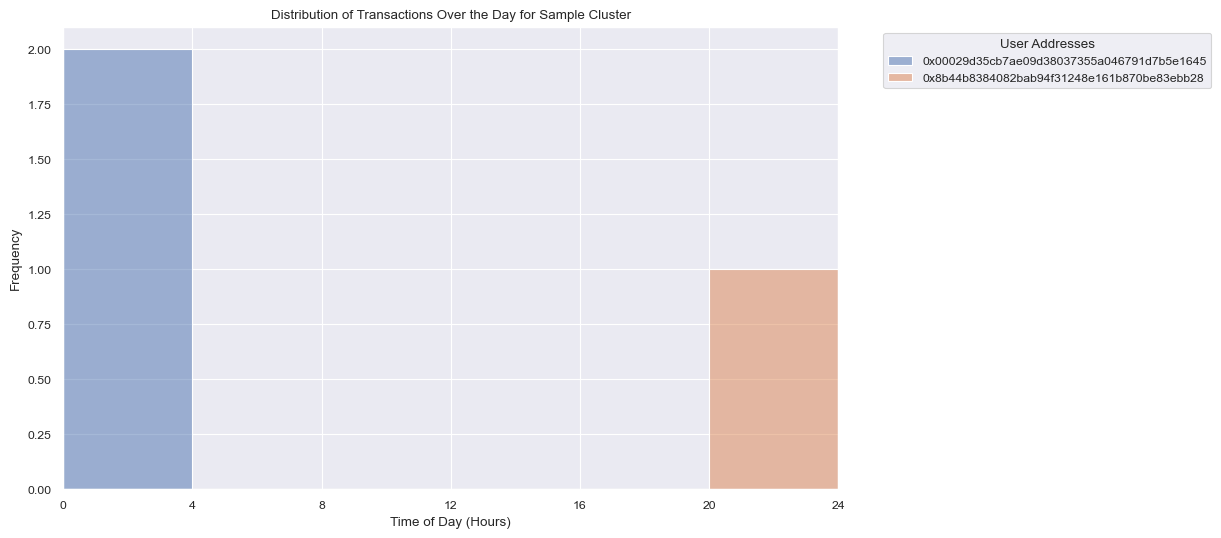

In [163]:
# Create a list of unique addresses
addresses = df['from'].unique()

# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(addresses)))

plt.figure(figsize=[10,6])

bins = np.linspace(0, 24, num=7)

# Plot histogram for each user address
for address in addresses:
    subset = df[df['from'] == address]
    sns.histplot(subset['hour_of_day'], bins=bins, label=address, alpha=0.5)

sns.set_theme(context='paper')
plt.xlabel('Time of Day (Hours)')
plt.xticks(bins)
plt.ylabel('Frequency')
plt.xlim((0,24))
plt.title('Distribution of Transactions Over the Day for Sample Cluster')
plt.legend(title='User Addresses', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside of plot
plt.show()

### Use transactions

### Try network visualization

In [ ]:
df = graph_df.sample(n=100)

# Create a graph from the dataframe
G = nx.from_pandas_edgelist(df, 'address1', 'address2')

# calculate degree for each node and use it as the node size in the plot
degree = nx.degree(G)
node_sizes = [v * 10 for v in dict(degree).values()]

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, seed=100)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.7)
# nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='grey', width=0.5)

plt.axis("off")
plt.show()